# Customer Segmentation

This workbook is to segement the customers with various info into several clusters

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn import metrics

aisle_path = 'E:\Sebnewrepo\Data/aisles.csv'
aisles = pd.read_csv(aisle_path)

departments_path = 'E:\Sebnewrepo\Data/departments.csv'
departments = pd.read_csv(departments_path)

order_products_path = 'E:\Sebnewrepo\Data/order_products.csv'
order_products = pd.read_csv(order_products_path)

orders_path = 'E:\Sebnewrepo\Data/orders.csv'
orders = pd.read_csv(orders_path)

products_path = 'E:\Sebnewrepo\Data/products.csv'
products = pd.read_csv(products_path)

### 1. Users and Aisles

#### 1.1 Prepare the table

In [82]:
joint = order_products.merge(orders, on = 'order_id', how = 'left')
joint = joint.merge(products, on = 'product_id', how = 'left')
joint.head()

,order_id,product_id,add_to_cart_order,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,202279,3,5,9,8.0,Organic Egg Whites,86,16
1,2,28985,2,202279,3,5,9,8.0,Michigan Organic Kale,83,4
2,2,9327,3,202279,3,5,9,8.0,Garlic Powder,104,13
3,2,45918,4,202279,3,5,9,8.0,Coconut Butter,19,13
4,2,30035,5,202279,3,5,9,8.0,Natural Sweetener,17,13


In [118]:
df_joint = pd.DataFrame({
    'user_id' : joint['user_id'],
    'aisle_id' : joint['aisle_id']
})
df_joint01 = df_joint.merge(aisles, on = 'aisle_id', how = 'left')
df_joint01.head()

,user_id,aisle_id,aisle
0,202279,86,eggs
1,202279,83,fresh vegetables
2,202279,104,spices seasonings
3,202279,19,oils vinegars
4,202279,17,baking ingredients


In [105]:
#pivot the table:
#df_joint02 = df_joint01.drop(['aisle_id'], axis = 1)
new_df = pd.pivot_table(df_joint01, 
                   index = ['user_id'],
                   columns = ['aisle'],
                   aggfunc = 'count')
new_df = new_df.fillna(0)
new_df.head()

aisle_id                               \
aisle   air fresheners candles asian foods baby accessories   
user_id                                                       
1                          0.0         0.0              0.0   
2                          0.0         3.0              0.0   
3                          0.0         0.0              0.0   
4                          0.0         0.0              0.0   
5                          1.0         4.0              0.0   

                                                               \
aisle   baby bath body care baby food formula bakery desserts   
user_id                                                         
1                       0.0               0.0             0.0   
2                       0.0               0.0             0.0   
3                       0.0               0.0             0.0   
4                       0.0               0.0             0.0   
5                       0.0               0.0             0.0   

                                                                       ...  \
aisle   baking ingredients baking supplies decor beauty beers coolers  ...   
user_id                                                                ...   
1                      0.0                   0.0    0.0           0.0  ...   
2                      2.0                   0.0    0.0           0.0  ...   
3                      0.0                   0.0    0.0           0.0  ...   
4                      0.0                   0.0    0.0           0.0  ...   
5                      0.0                   0.0    0.0           0.0  ...   

                                                                  \
aisle   spreads  tea tofu meat alternatives tortillas flat bread   
user_id                                                            
1           1.0  0.0                    0.0                  0.0   
2           3.0  1.0                    1.0                  0.0   
3           4.0  1.0                    0.0                  0.0   
4           0.0  0.0                    0.0                  1.0   
5           0.0  0.0                    0.0                  0.0   

                                                                    \
aisle   trail mix snack mix trash bags liners vitamins supplements   
user_id                                                              
1                       0.0               0.0                  0.0   
2                       0.0               0.0                  0.0   
3                       0.0               0.0                  0.0   
4                       0.0               0.0                  0.0   
5                       0.0               0.0                  0.0   

                                                          
aisle   water seltzer sparkling water white wines yogurt  
user_id                                                   
1                                 0.0         0.0    2.0  
2                                 2.0         0.0   42.0  
3                                 2.0         0.0    0.0  
4                                 1.0         0.0    0.0  
5                                 0.0         0.0    3.0  

[5 rows x 134 columns]

In [106]:
# drop the multi-level index
new_df.columns = new_df.columns.droplevel()
new_df = pd.DataFrame(
    new_df.values,
    index = new_df.index,
    columns = new_df.columns
)
new_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,3.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,42.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


#### 1.2 Customer Segmentation with PCA & Clustering 

In [126]:
def pca_process(n, df):
    pca = decomposition.PCA(n_components = n)
    pca_data = pca.fit_transform(df)

    ## get PCs, show Explained variance per principal component
    pca_df = pd.DataFrame(pca_data)
    print('Explained variance per principal component:',pca.explained_variance_ratio_)
    return pca_df

def standard(df):
    ss = StandardScaler()
    df1 = pd.DataFrame(ss.fit_transform(df))
    return df1

def kmeans(k, df):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df)
    y_kmeans = kmeans.fit_predict(df)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    sse = kmeans.inertia_
    return (y_kmeans, centers, labels, sse)

# CH Score Check
def CH_Score(df):
    i = []
    CH_score = []
    max_k = len(pca_data1.index)
    for k in range(2,10):
        y_kmeans, centers, labels, sse= kmeans(k,df)
        m = metrics.calinski_harabasz_score(df, labels)
        i.append(k)
        CH_score.append(m)

    plt.figure()  
    plt.plot(i,CH_score)  
    plt.xlabel("kmeans-k")  
    plt.ylabel("calinski_harabaz_score")  
    plt.title("Performance of K") 
    return
# SSE
def sse(df):
    k_range = range(1,15)
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(new_df)
        sse.append(kmeans.inertia_)
    plt.plot(k_range, sse)

1.2.1 Try PCA to reduct the demension and evaluate the performance

In [7]:
##Try n = 2
pca_data1 = pca_process(2, new_df)
pca_data1

Explained variance per principal component: [0.4786378  0.09640584]


,0,1
0,-24.811636,3.449194
1,10.331587,39.529394
2,-9.247469,2.382705
3,-29.242883,-0.880036
4,-19.186003,-3.037863
...,...,...
206204,-20.426644,5.176026
206205,-6.163290,-0.200366
206206,7.312526,7.660427
206207,82.725416,20.649796


In [8]:
##Try n = 3
pca_data2 = pca_process(3, new_df)
pca_data2

Explained variance per principal component: [0.4786378  0.09640584 0.05210072]


,0,1,2
0,-24.811636,3.449192,-1.611604
1,10.331587,39.529397,4.610985
2,-9.247469,2.382711,-11.077053
3,-29.242883,-0.880035,-1.984252
4,-19.186003,-3.037863,0.186750
...,...,...,...
206204,-20.426644,5.176025,0.814340
206205,-6.163290,-0.200361,5.265617
206206,7.312526,7.660423,7.951990
206207,82.725416,20.649791,8.150550


Try Kmeans to cluster the data

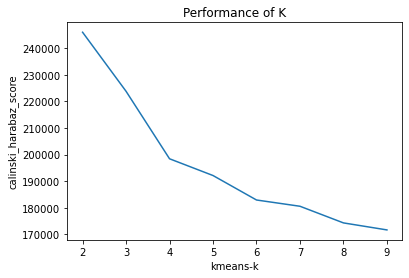

In [9]:
# Use 2 demension data First
CH_Score(pca_data1)

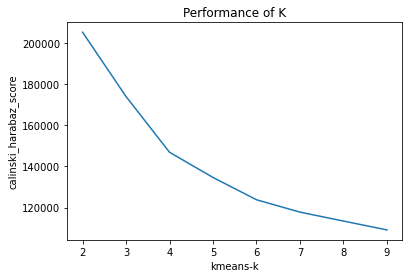

In [10]:
# Use 3 demension data
CH_Score(pca_data2)

The CH score says 2 cluster is the best. Technically it does not make much sense.
Apply Standardization after PCA

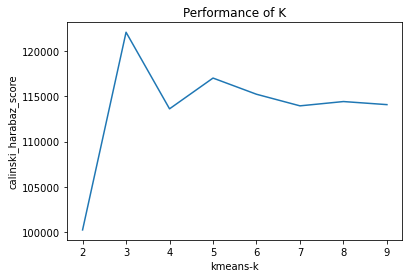

In [11]:
# Use 2 demension data
pca_data1 = standard(pca_data1)
CH_Score(pca_data1)

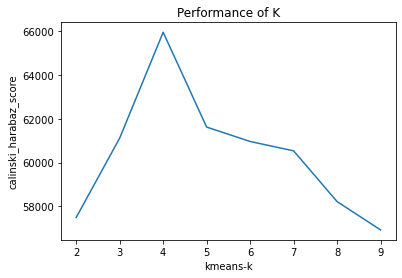

In [12]:
# Use 3 demension data
pca_data2 = standard(pca_data2)
CH_Score(pca_data2)

According to the figures, when utilizing StandardScaler, the CH Score makes more sense compared with the previous attempt. if demension = 2, the 3 clusters is the best solution. If demension = 3, the 4 cluster is the best solution.

Plot these two result

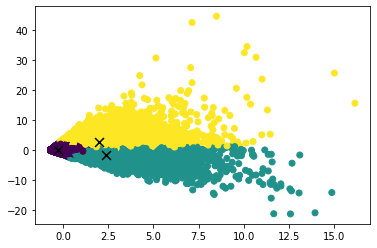

In [13]:
# n = 2, k = 3
y_kmeans, centers, label, sse = kmeans(3, pca_data1)

plt.scatter(pca_data1[0],pca_data1[1], c = y_kmeans, cmap = 'viridis' )
plt.scatter(centers[:,0], centers[:, 1], c='black', s=80, marker='x')

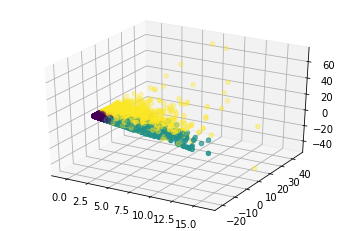

In [14]:
# n = 3, k = 4
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(pca_data2[0], pca_data2[1], pca_data2[2], c = y_kmeans, cmap = 'viridis')

#### 1.3 Customer Segmentation Analysis

Use the PCA Data to analyze first

1.3.1 Result from 2-demension transformed table

In [15]:
# Reconstruct the result
y_kmeans, centers, label, sse = kmeans(3, pca_data1)

In [16]:
# add label to original df
new_df1 = new_df
new_df1['label'] = label
new_df1.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,label
users_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1
2,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,42.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
5,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1


In [17]:
label_0 = new_df1[new_df1.label == 0]
label_1 = new_df1[new_df1.label == 1]
label_2 = new_df1[new_df1.label == 2]

print('How many users are assgined to each label?')
print('Label 0: '+ str(label_0.shape[0]))
print('Label 1: '+ str(label_1.shape[0]))
print('Label 2: '+ str(label_2.shape[0]))

How many users are assgined to each label?
Label 0: 12996
Label 1: 183412
Label 2: 9801


For here we try to see the 

In [18]:
#see the distribution of the total count of each aisle in each label
l = label_0.mean().sort_values(ascending = False)
print('Customer buying preferrence of Label 0')
l.head(10)

Customer buying preferrence of Label 0


aisle
fresh vegetables                 105.242690
fresh fruits                      72.419668
packaged vegetables fruits        36.600723
yogurt                            16.786473
packaged cheese                   15.468298
milk                              13.089797
fresh herbs                       11.982610
soy lactosefree                   11.300323
frozen produce                     9.901970
water seltzer sparkling water      8.927824
dtype: float64

In [19]:
l = label_1.mean().sort_values(ascending = False)
print('Customer buying preferrence of Label 1')
l.head(10)

Customer buying preferrence of Label 1


aisle
fresh fruits                     10.801398
fresh vegetables                 10.118335
packaged vegetables fruits        5.660747
yogurt                            4.185048
packaged cheese                   3.320355
water seltzer sparkling water     3.090103
milk                              2.866110
chips pretzels                    2.605653
soy lactosefree                   2.115401
bread                             2.005240
dtype: float64

In [20]:
l = label_2.mean().sort_values(ascending = False)
print('Customer buying preferrence of Label 2')
l.head(10)

Customer buying preferrence of Label 2


aisle
fresh fruits                     88.806142
yogurt                           53.243343
fresh vegetables                 35.207836
packaged vegetables fruits       33.659218
milk                             23.249158
packaged cheese                  21.573615
water seltzer sparkling water    19.932864
chips pretzels                   17.273033
energy granola bars              15.068666
baby food formula                14.309560
dtype: float64

From here we can see that the customer behaviors in three labels are similar. So maybe using PCA here do not bring more assistance.

#### 1.3 Customer Segmentation with Clustering Only

In [21]:
# directly try kmeans and evaluate its performance 
new_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,label
users_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1
2,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,42.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
5,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1


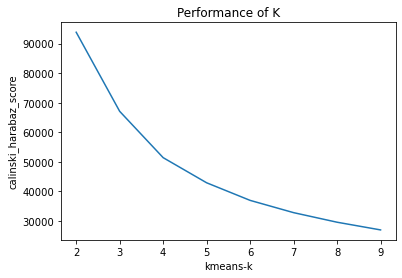

In [22]:
#Use CH Score and SSE to evaluate the number of clusters
CH_Score(new_df)

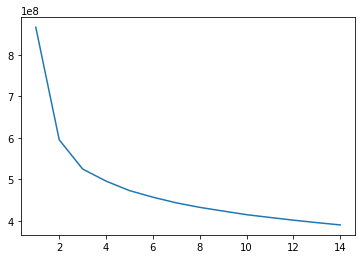

In [27]:
sse(new_df)

2 clusters or 3 clusters might be well here

In [28]:
# 2 Clusters Analysis
y_kmeans, centers, label, sse = kmeans(2, new_df)
new_df1 = new_df
new_df1['label'] = label
new_df1.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,label
users_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
2,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,42.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
5,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0


In [60]:
label_0 = new_df1[new_df1.label == 0]
label_1 = new_df1[new_df1.label == 1]

print('How many users are assgined to each label?')
print('Label 0: '+ str(label_0.shape[0]))
print('Label 1: '+ str(label_1.shape[0]))

How many users are assgined to each label?
Label 0: 186740
Label 1: 19469


In [61]:
#see the distribution of the total count of each aisle in each label
l = label_0.mean().sort_values(ascending = False)
print('Customer buying preferrence of Label 0')
l.head(10)

Customer buying preferrence of Label 0


aisle
fresh fruits                     11.033994
fresh vegetables                 10.385916
packaged vegetables fruits        5.720135
yogurt                            4.675667
packaged cheese                   3.400032
water seltzer sparkling water     3.340372
milk                              2.991041
chips pretzels                    2.747954
soy lactosefree                   2.209671
refrigerated                      2.094088
dtype: float64

In [63]:
l1 = label_1.mean().sort_values(ascending = False)
print('Customer buying preferrence of Label 1')
l1.head(10)

Customer buying preferrence of Label 1


aisle
fresh fruits                     88.970825
fresh vegetables                 83.679901
packaged vegetables fruits       39.839129
yogurt                           32.587652
packaged cheese                  19.854127
milk                             18.753506
water seltzer sparkling water    13.065335
soy lactosefree                  12.936412
chips pretzels                   12.357389
bread                            11.625713
dtype: float64

Text(0.5, 1.0, 'Label 0 and Label 1 Customer Stats')

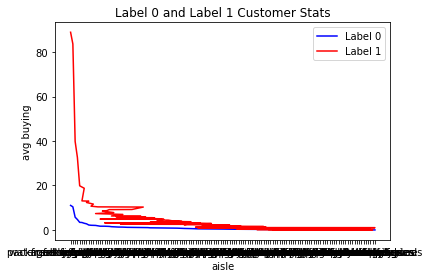

In [68]:
plt.figure()  
plt.plot(l, "-b", label="Label 0")
plt.plot(l1, "-r", label="Label 1")
plt.xlabel("aisle")  
plt.ylabel("avg buying")  
plt.legend(loc="upper right")
plt.title("Label 0 and Label 1 Customer Stats") 

#### 1.4 Customer Segmentation Further Explore
From this two clusters, we can make an attempt that: our customers can be divided into two groups: group 1: Small Quantity Purchasing, group 2: large Quantity Purchasing. Further more, is customers in group 1 has higher number or frequency of purchases than people in group 2

In [32]:
new_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,label
users_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
2,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,42.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
5,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0


In [47]:
joint = pd.DataFrame({
    'label': new_df['label']
})
joint = joint.reset_index()
joint.columns = ['user_id','label']
joint.head()

,user_id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [48]:
# join the order.csv and the table above
joint02 = orders.merge(joint,  on = 'user_id', how = 'left')
joint02.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,label
0,2539329,1,1,2,8,NaN,0
1,2398795,1,2,3,7,15.0,0
2,473747,1,3,3,12,21.0,0
3,2254736,1,4,4,7,29.0,0
4,431534,1,5,4,15,28.0,0


In [56]:
label_0 = joint02[joint02.label == 0]
label_1 = joint02[joint02.label == 1]

a = label_0['order_id'].groupby(label_0['user_id']).count()
print('Average time of purchases of Label 0')
print(a.mean())
a

Average time of purchases of Label 0
13.223867409232087


user_id
1         11
2         15
3         13
4          6
5          5
          ..
206204     5
206205     4
206206    68
206207    17
206209    14
Name: order_id, Length: 186740, dtype: int64

In [58]:
a = label_0['days_since_prior_order'].groupby(label_0['user_id']).mean()
print('Average time interval of purchases of Label 0')
print(a.mean())
a

Average time interval of purchases of Label 0
16.233413306564472


user_id
1         19.000000
2         16.285714
3         12.000000
4         17.000000
5         11.500000
            ...    
206204    14.750000
206205    16.666667
206206     3.716418
206207    14.312500
206209    18.461538
Name: days_since_prior_order, Length: 186740, dtype: float64

In [57]:
a = label_1['order_id'].groupby(label_1['user_id']).count()
print('Average time of purchases of Label 1')
print(a.mean())
a

Average time of purchases of Label 1
48.88068211002106


user_id
27        82
50        68
54        78
63        40
86        18
          ..
206158    51
206174    53
206187    35
206193    42
206208    50
Name: order_id, Length: 19469, dtype: int64

In [59]:
a = label_1['days_since_prior_order'].groupby(label_1['user_id']).mean()
print('Average time interval of purchases of Label 1')
print(a.mean())
a

Average time interval of purchases of Label 1
7.921853024146338


user_id
27         4.432099
50         5.432836
54         4.727273
63         9.230769
86        19.411765
            ...    
206158     7.280000
206174     6.557692
206187    10.235294
206193     5.780488
206208     7.367347
Name: days_since_prior_order, Length: 19469, dtype: float64

##### Conclusion
From the attempt above, the customers can be divided into two groups:

Group 1 (Normal Customer): The customers' time of purchase is 13.2, and the interval period between two purchase is 16.2 days, 90% Customers are in this group

Group 2 (Frequent Customer): The customers' time of purchase is 48.8 (much higher than group 1), and the interval period between two purchase is 7.9 days (half of Group 1), 10% Customers are in this group

#### 1.5 Is that other measurement or approach to analyze the customer segmentation?

How about binary table for the original data set: if user have purchase on the aisle, just count as 1, instead of certain quantity?

In [120]:
df_joint01_bin = df_joint01
df_joint01_bin.loc[df_joint01_bin['aisle_id'] > 0, 'aisle_id'] = 1
df_joint01_bin.head()

,user_id,aisle_id,aisle
0,202279,1,eggs
1,202279,1,fresh vegetables
2,202279,1,spices seasonings
3,202279,1,oils vinegars
4,202279,1,baking ingredients


In [122]:
new_df_bin = pd.pivot_table(df_joint01, 
                   index = ['user_id'],
                   columns = ['aisle'],
                   aggfunc = 'max')
new_df_bin = new_df_bin.fillna(0)
new_df_bin.columns = new_df_bin.columns.droplevel()
new_df_bin = pd.DataFrame(
        new_df_bin.values,
        index = new_df_bin.index,
        columns = new_df_bin.columns
)
new_df_bin.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


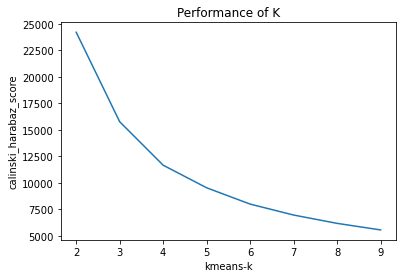

In [124]:
#Show CH Score of this table
CH_Score(new_df_bin)    

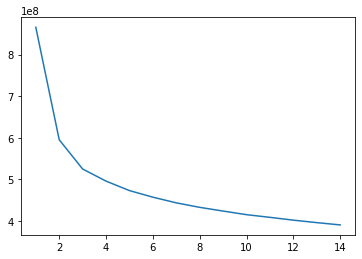

In [127]:
sse(new_df_bin)

In [128]:
y_kmeans, centers, label, sse = kmeans(2, new_df_bin)
new_df_bin1 = new_df_bin
new_df_bin1['label'] = label
new_df_bin1.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,label
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [129]:
label_0 = new_df_bin1[new_df_bin1.label == 0]
label_1 = new_df_bin1[new_df_bin1.label == 1]

print('How many users are assgined to each label?')
print('Label 0: '+ str(label_0.shape[0]))
print('Label 1: '+ str(label_1.shape[0]))

How many users are assgined to each label?
Label 0: 83786
Label 1: 122423


In [130]:
l = label_0.mean().sort_values(ascending = False)
print('Customer buying preferrence of Label 0')
l.head(10)

Customer buying preferrence of Label 0


aisle
fresh fruits                  0.975640
fresh vegetables              0.962715
packaged vegetables fruits    0.958788
packaged cheese               0.919712
yogurt                        0.848960
chips pretzels                0.789070
bread                         0.766882
frozen produce                0.750865
milk                          0.742666
soup broth bouillon           0.700642
dtype: float64

In [136]:
label_1.label = 0
l1 = label_1.mean().sort_values(ascending = False)
print('Customer buying preferrence of Label 1')
l1.head(10)

Customer buying preferrence of Label 1


C:\Users\36038\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


aisle
fresh fruits                     0.796876
packaged vegetables fruits       0.671688
fresh vegetables                 0.659353
packaged cheese                  0.483341
yogurt                           0.457733
water seltzer sparkling water    0.415012
milk                             0.405447
chips pretzels                   0.400962
soy lactosefree                  0.355407
bread                            0.345246
dtype: float64

Text(0.5, 1.0, 'Label 0 and Label 1 Customer Stats')

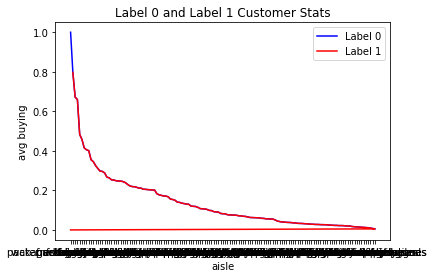

In [137]:
# Plot
plt.figure()  
plt.plot(l, "-b", label="Label 0")
plt.plot(l1, "-r", label="Label 1")
plt.xlabel("aisle")  
plt.ylabel("avg buying")  
plt.legend(loc="upper right")
plt.title("Label 0 and Label 1 Customer Stats") 

In [138]:
joint = pd.DataFrame({
    'label': new_df_bin1['label']
})
joint = joint.reset_index()
joint.columns = ['user_id','label']
joint.head()

,user_id,label
0,1,1
1,2,0
2,3,1
3,4,1
4,5,1


In [139]:
joint02 = orders.merge(joint,  on = 'user_id', how = 'left')
joint02.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,label
0,2539329,1,1,2,8,NaN,1
1,2398795,1,2,3,7,15.0,1
2,473747,1,3,3,12,21.0,1
3,2254736,1,4,4,7,29.0,1
4,431534,1,5,4,15,28.0,1


In [140]:
label_0 = joint02[joint02.label == 0]
label_1 = joint02[joint02.label == 1]

a = label_0['order_id'].groupby(label_0['user_id']).count()
print('Average time of purchases of Label 0')
print(a.mean())
a

Average time of purchases of Label 0
25.017329864177785


user_id
2         15
7         21
10         6
11         8
12         6
          ..
206203     6
206206    68
206207    17
206208    50
206209    14
Name: order_id, Length: 83786, dtype: int64

In [141]:
a = label_0['days_since_prior_order'].groupby(label_0['user_id']).mean()
print('Average time interval of purchases of Label 0')
print(a.mean())
a

Average time interval of purchases of Label 0
12.953077419565753


user_id
2         16.285714
7         10.450000
10        21.800000
11        18.714286
12        26.000000
            ...    
206203    29.400000
206206     3.716418
206207    14.312500
206208     7.367347
206209    18.461538
Name: days_since_prior_order, Length: 83786, dtype: float64

In [142]:
a = label_1['order_id'].groupby(label_1['user_id']).count()
print('Average time of purchases of Label 1')
print(a.mean())
a

Average time of purchases of Label 1
10.822974441077248


user_id
1         11
3         13
4          6
5          5
6          4
          ..
206197    24
206198     8
206202    23
206204     5
206205     4
Name: order_id, Length: 122423, dtype: int64

In [144]:
a = label_1['days_since_prior_order'].groupby(label_1['user_id']).mean()
print('Average time interval of purchases of Label 1')
print(a.mean())
a

Average time interval of purchases of Label 1
17.15667491173347


user_id
1         19.000000
3         12.000000
4         17.000000
5         11.500000
6         13.333333
            ...    
206197    13.086957
206198    18.285714
206202    12.500000
206204    14.750000
206205    16.666667
Name: days_since_prior_order, Length: 122423, dtype: float64